In [0]:
%tensorflow_version 2.x
import tensorflow as tf 
from keras.models import Sequential,Model,save_model,load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd 
import os
from os.path import join 
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bharadwajvedula","key":"358f0fc9aaf97dbfb019b494b2548efd"}'}

In [0]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 10.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=ea8fbfa79b8a86f352073c3b013a3b589da6b0f5098368e2287aec1469f17a41
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sur

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:37<00:00, 85.9MB/s]
100% 2.29G/2.29G [00:37<00:00, 66.6MB/s]


In [0]:
from zipfile import ZipFile
file_name="chest-xray-pneumonia.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


**UNDER SAMPLING**

In [0]:
list1=os.listdir('/content/chest_xray/train/PNEUMONIA')
list2=os.listdir('/content/chest_xray/train/NORMAL')


In [0]:
len(list1),len(list2)

(3875, 1341)

In [0]:
%mkdir trash 



In [0]:
source="/content/chest_xray/train/PNEUMONIA"
destination="/content/trash"

In [0]:
for i in list1[1341:]:
  shutil.move(join(source,i),join(destination,i))

In [0]:
list3=os.listdir('/content/chest_xray/train/PNEUMONIA')
print(len(list3))

1341


In [0]:
train_path="/content/chest_xray/train"
valid_path="/content/chest_xray/val"
test_path="/content/chest_xray/test"

In [0]:
train_imagedatagenerator=ImageDataGenerator(
     rescale            = 1/255    ,
  rotation_range     = 10        ,
  width_shift_range  = 0.1      ,
  height_shift_range = 0.05     ,
  shear_range        = 0.1      ,
  zoom_range         = 0.1     ,
  horizontal_flip    = True     ,
  vertical_flip      = False    ,
  fill_mode          = "nearest",
  brightness_range=[0.5, 1.5]
)
valid_imagedatagenerator=ImageDataGenerator(
    
    rescale            = 1/255    

)
test_imagedatagenerator=ImageDataGenerator(
    rescale=1/255
)

In [0]:
train=train_imagedatagenerator.flow_from_directory(
    train_path,
    target_size=(299,299),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True
)
valid=valid_imagedatagenerator.flow_from_directory(
    valid_path,
    target_size=(299,299),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True
)
test=test_imagedatagenerator.flow_from_directory(
    test_path,
    target_size=(299,299),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 2682 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


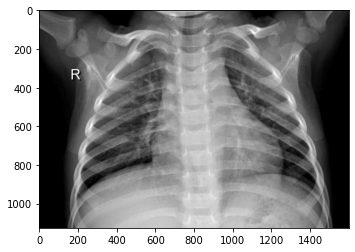

In [0]:
import cv2 as cv
img=cv.imread("/content/chest_xray/train/NORMAL/IM-0125-0001.jpeg")
plt.imshow(img)
plt.show()


In [0]:
xception_model=Xception(include_top=False,weights='imagenet',input_shape=(299,299,3))
x=xception_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(32,activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(16,activation='relu')(x)
x=Dropout(0.3)(x)
predictions=Dense(1,activation='sigmoid')(x)

model1=Model(inputs=xception_model.input,outputs=predictions)

for layer in model1.layers[:46]:
  layer.trainable=False

model1.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
layers_info=[(layer,layer.name,layer.trainable) for layer in model1.layers]

layer_info=pd.DataFrame(layers_info,columns=['layer_type','layer_name','trainable'])
layer_info.head(50)

,layer_type,layer_name,trainable
0,<keras.engine.input_layer.InputLayer object at...,input_9,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.normalization.BatchNormalization...,block1_conv1_bn,False
3,<keras.layers.core.Activation object at 0x7f50...,block1_conv1_act,False
4,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
5,<keras.layers.normalization.BatchNormalization...,block1_conv2_bn,False
6,<keras.layers.core.Activation object at 0x7f50...,block1_conv2_act,False
7,<keras.layers.convolutional.SeparableConv2D ob...,block2_sepconv1,False
8,<keras.layers.normalization.BatchNormalization...,block2_sepconv1_bn,False
9,<keras.layers.core.Activation object at 0x7f50...,block2_sepconv2_act,False


In [0]:
model1.compile(
    loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy']
    )

In [0]:

model_checkpoint=ModelCheckpoint('best_xception.h5',monitor='val_accuracy',save_best_only=True,mode='max')
early_stopping=EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=0,mode="max",restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="loss",factor=0.2,patience=10,min_lr=0.001)

In [0]:
history = model1.fit_generator(
    train,
    steps_per_epoch=train.n//train.batch_size,
    epochs=20,
    validation_data=valid,
    callbacks=[model_checkpoint,early_stopping,reduce_lr]
)

Epoch 1/20
83/83 [==============================] - 116s 1s/step - loss: 0.4133 - accuracy: 0.8419 - val_loss: 14.1521 - val_accuracy: 0.7500
Epoch 2/20
83/83 [==============================] - 111s 1s/step - loss: 0.2114 - accuracy: 0.9253 - val_loss: 3.6660e-08 - val_accuracy: 1.0000
Epoch 3/20
83/83 [==============================] - 109s 1s/step - loss: 0.1565 - accuracy: 0.9449 - val_loss: 1.5609 - val_accuracy: 0.7500
Epoch 4/20
83/83 [==============================] - 110s 1s/step - loss: 0.1028 - accuracy: 0.9657 - val_loss: 3.0051 - val_accuracy: 0.6875
Epoch 5/20
83/83 [==============================] - 110s 1s/step - loss: 0.1195 - accuracy: 0.9660 - val_loss: 0.2095 - val_accuracy: 0.8125
Epoch 6/20
83/83 [==============================] - 110s 1s/step - loss: 0.0870 - accuracy: 0.9736 - val_loss: 0.7842 - val_accuracy: 0.8125
Epoch 7/20
83/83 [==============================] - 110s 1s/step - loss: 0.0772 - accuracy: 0.9732 - val_loss: 13.0646 - val_accuracy: 0.5000
Epoch 8

In [0]:
test.reset()

In [0]:

pred=model1.predict_generator(test,verbose=1)

20/20 [==============================] - 9s 450ms/step


In [0]:
y_pred=[]
for i in range(len(pred)):
  if pred[i]>= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)


In [0]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [0]:
y_true=test.labels

In [0]:
print(confusion_matrix(y_true,y_pred))

[[195  39]
 [ 33 357]]


In [0]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       234
           1       0.90      0.92      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.88      0.88      0.88       624



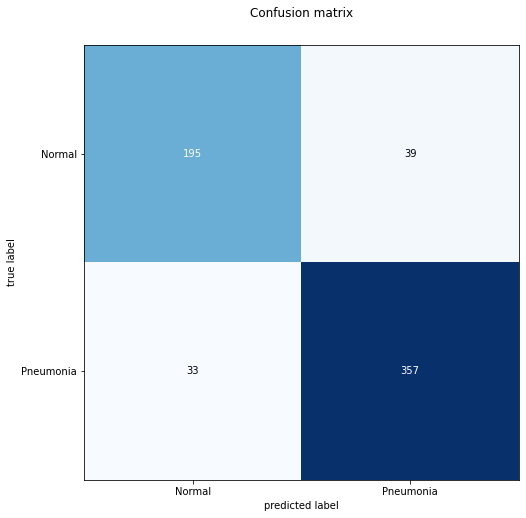

In [0]:
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [0]:
precision=357/(357+39)
recall=357/(389+33)

In [0]:
precision,recall

(0.9015151515151515, 0.8459715639810427)

In [0]:
model1.save('Xception_model.h5')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mv best_xception.h5 models


In [0]:
os.listdir("/content/drive")

['.shortcut-targets-by-id', 'My Drive', '.Trash']

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_pred,y_true)

0.878389154704944

In [0]:
from keras.preprocessing import image
imagePath='/content/n-2.jpg'
test_image2 = image.load_img(imagePath, target_size = (299, 299)) 
test_arr = image.img_to_array(test_image2)
test_arr = np.expand_dims(test_arr, axis = 0)
test_arr /= 255.0
#predict the result
result = model1.predict(test_arr)

In [0]:
result

array([[0.]], dtype=float32)

In [0]:
!mv Xception_model.h5 models